In [12]:
import os
import pandas as pd
import pickle
import numpy as np
from shogun import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace
import random
import seaborn as sns
import time
import tqdm
import hypothesisTesting.shogunMMDutils as mmdutils
import matplotlib as mpl

In [13]:
mpl.get_configdir()
graphicsLocation = '/home/ak/Documents/Research/Papers/StylisedFactsPaper/figures'

In [14]:
plt.style.use(os.path.join(mpl.get_configdir(),'latexstyle.mplstyle'))

In [15]:
import stylised_facts_data_utilities.createLOB as createLOB

In [16]:


X, Y = mmdutils.sample_gaussian_vs_laplace()

In [17]:
# use scipy for generating samples
from scipy.stats import norm, laplace

def sample_gaussian_vs_laplace(n=220, mu=0.0, sigma2=1, b=np.sqrt(0.5)):    
    # sample from both distributions
    X=norm.rvs(size=n, loc=mu, scale=sigma2)
    Y=laplace.rvs(size=n, loc=mu, scale=b)
    
    return X,Y

In [18]:
from scipy.stats import gumbel_r
mean, var, skew, kurt = gumbel_r.stats(moments='mvsk')

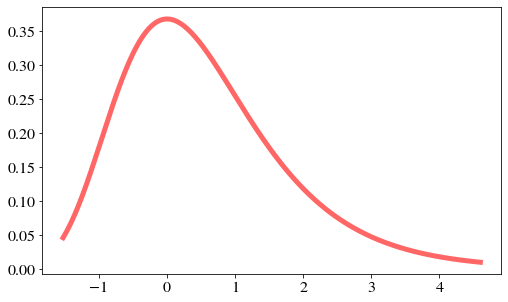

In [20]:
fig, ax = plt.subplots(1, 1)
n=1000
x = np.linspace(gumbel_r.ppf(0.01),
                gumbel_r.ppf(0.99), n)

ax.plot(x, gumbel_r.pdf(x),
       'r-', lw=5, alpha=0.6, label='gumbel_r pdf')#

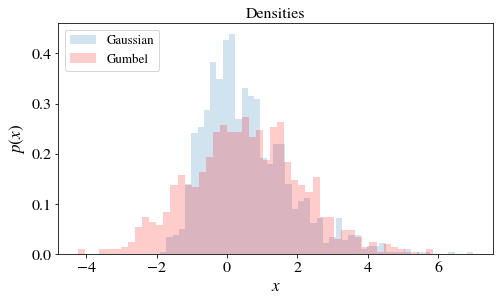

In [21]:
#Generate random numbers:

r = gumbel_r.rvs(size=n)
mu = np.average(r)
sigma2 = np.var(r)
normal=norm.rvs(size=n, loc=mu, scale=sigma2)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2, bins=50)
plt.hist(normal, density=True, color='r',histtype='stepfilled', alpha=0.2, bins=50)
ax.legend(loc='best', frameon=False)
plt.title("Densities")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
_=plt.legend([ 'Gaussian','Gumbel'])
plt.show()

In [22]:
sigma2

1.5901598183911605

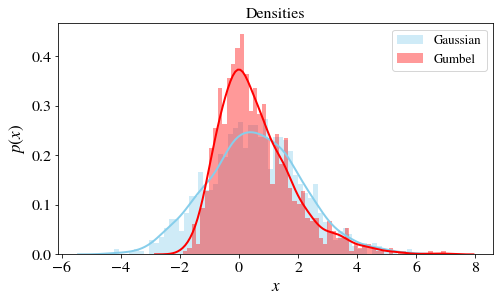

In [23]:
bins =60
sns.distplot(normal, bins =bins, color = "skyblue", label ="Gaussian")
sns.distplot(r, bins =bins,color = "red", label ="Gumbel")
plt.title("Densities")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
_=plt.legend([ 'Gaussian','Gumbel'])

plt.legend()

title= 'DistributionsExample.png'
plt.savefig(os.path.join(graphicsLocation,title))
plt.show()

In [24]:
from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """
    If Y=None, then this computes the distance between X and itself
    """
    assert(X.ndim==2)

    # IMPLEMENT: compute pairwise distance matrix. Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = cdist(X, Y, 'sqeuclidean')

    return sq_dists

def gauss_kernel(X, Y=None, sigma=1.0):
    """
    Computes the standard Gaussian kernel k(x,y)=exp(- ||x-y||**2 / (2 * sigma**2))

    X - 2d array, samples on left hand side
    Y - 2d array, samples on right hand side, can be None in which case they are replaced by X
    
    returns: kernel matrix
    """

    # IMPLEMENT: compute squared distances and kernel matrix
    sq_dists = sq_distances(X,Y)
    K = np.exp(-sq_dists / (2 * sigma**2))
    return K

# IMPLEMENT
def linear_kernel(X, Y):
    return np.dot(X, Y.T)

In [25]:
def quadratic_time_mmd(X,Y,kernel):
    assert X.ndim == Y.ndim == 2
    K_XX = kernel(X,X)
    K_XY = kernel(X,Y)
    K_YY = kernel(Y,Y)
       
    n = len(K_XX)
    m = len(K_YY)
    
    # IMPLEMENT: unbiased MMD statistic (could also use biased, doesn't matter if we use permutation tests)
    np.fill_diagonal(K_XX, 0)
    np.fill_diagonal(K_YY, 0)
    mmd = np.sum(K_XX) / (n*(n-1))  + np.sum(K_YY) / (m*(m-1))  - 2*np.sum(K_XY)/(n*m)
    return mmd

In [26]:
def two_sample_permutation_test(test_statistic, X, Y, num_permutations, prog_bar=True):
    assert X.ndim == Y.ndim
    
    statistics = np.zeros(num_permutations)
    
    range_ = range(num_permutations)
    for i in range_:
        # concatenate samples
        if X.ndim == 1:
            Z = np.hstack((X,Y))
        elif X.ndim == 2:
            Z = np.vstack((X,Y))
            
        # IMPLEMENT: permute samples and compute test statistic
        perm_inds = np.random.permutation(len(Z))
        Z = Z[perm_inds]
        X_ = Z[:len(X)]
        Y_ = Z[len(X):]
        my_test_statistic = test_statistic(X_, Y_)
        statistics[i] = my_test_statistic
    return statistics

In [27]:
def plot_permutation_samples(null_samples, statistic=None, title=None):
    #plt.hist(
    sns.distplot(null_samples, bins=50, color='grey')
    plt.axvline(x=np.percentile(null_samples, 2.5), c='b')
    legend = ["95% quantiles"]
    if statistic is not None:
        plt.axvline(x=statistic, c='r', linewidth=3, linestyle='--')
        legend += ["Actual test statistic"]
    plt.legend(legend, loc='best')
    plt.axvline(x=np.percentile(null_samples, 97.5), c='b')
    plt.xlabel("Test statistic value")
    plt.ylabel("Counts")
    if title is not None:
        plt.savefig(os.path.join(graphicsLocation,title))

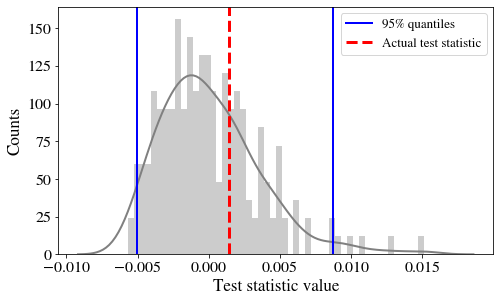

In [33]:
my_kernel = lambda X,Y : gauss_kernel(X,Y,sigma=0.2)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)
num_permutations = 200
statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic, title='ExampleTestStatistic.png')

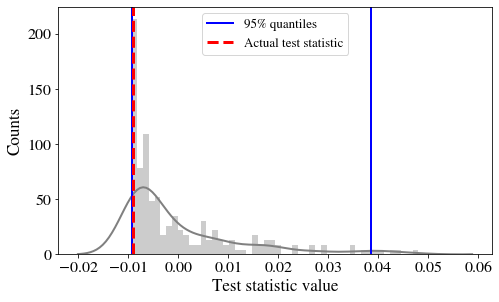

In [34]:
# IMPLEMENT: visualize test using linear kernel
my_kernel = lambda X,Y : linear_kernel(X,Y)
my_mmd = lambda X,Y : quadratic_time_mmd(X[:,np.newaxis],Y[:,np.newaxis], my_kernel)

statistics = two_sample_permutation_test(my_mmd, X, Y, num_permutations)
my_statistic = my_mmd(X,Y)

plot_permutation_samples(statistics, my_statistic)

/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/home/ak/anaconda3/envs/ds3_kernels/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


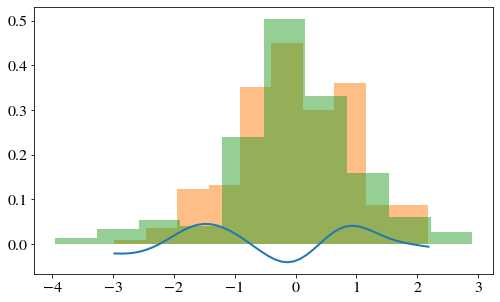

In [35]:
grid = np.linspace(np.min(X), np.max(X))

my_kernel = lambda X,Y : gauss_kernel(X,Y, sigma=0.5)

# IMPLEMENT: evaluate MMD witness function on grid
phi_X = np.mean(my_kernel(X[:,np.newaxis], grid[:,np.newaxis]), axis=0)
phi_Y = np.mean(my_kernel(Y[:,np.newaxis], grid[:,np.newaxis]), axis=0)
witness = phi_X-phi_Y

plt.plot(grid, witness)

plt.hist(X, alpha=0.5, normed=True)
plt.hist(Y, alpha=0.5, normed=True);

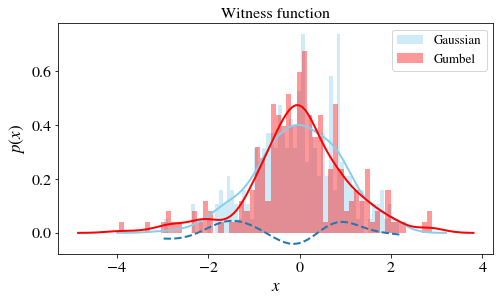

In [36]:
grid = np.linspace(np.min(X), np.max(X))

my_kernel = lambda X,Y : gauss_kernel(X,Y, sigma=0.5)
sns.distplot(X, bins =bins, color = "skyblue", label ="Gaussian")
sns.distplot(Y, bins =bins,color = "red", label ="Gumbel")
plt.title("Witness function")
# IMPLEMENT: evaluate MMD witness function on grid
phi_X = np.mean(my_kernel(X[:,np.newaxis], grid[:,np.newaxis]), axis=0)
phi_Y = np.mean(my_kernel(Y[:,np.newaxis], grid[:,np.newaxis]), axis=0)
witness = phi_X-phi_Y
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
_=plt.legend([ 'Gaussian','Gumbel'])
plt.plot(grid, witness, linestyle ='--')
title='ExampleWitnessFunction.png'
plt.savefig(os.path.join(graphicsLocation,title))

### witness function for actual data ###